<div align="center">

# <font face="Gramond" color="mediumvioletred"> MovieInsightML – Revenue & Genre Prediction </font>

<hr style="border: 0.1px solid white; width: 800px;">

</div>


## <font face="Gramond" color="peachpuff"> All libraries </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
from textblob import TextBlob
import re
import ast

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## <font face="Gramond" color="peachpuff"> 1. Data Preparation </font>

In [2]:
from google.colab import drive
import pandas as pd

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set path to your CSV file on Google Drive
file_path = '/content/drive/MyDrive/ml_movies_data/train.csv'

# Step 3: Load CSV
df = pd.read_csv(file_path)

# Step 4: Explore the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))
print("\nData Types:")
print(df.dtypes)
print("\nBasic Statistics:")
print(df.describe())


Mounted at /content/drive
Dataset Shape: (577853, 20)

Column Names:
['id', 'title', 'genres', 'original_language', 'overview', 'popularity', 'production_companies', 'release_date', 'budget', 'revenue', 'runtime', 'status', 'tagline', 'vote_average', 'vote_count', 'credits', 'keywords', 'poster_path', 'backdrop_path', 'recommendations']

First 3 rows:
       id                                             title                      genres original_language                                           overview  popularity production_companies release_date      budget    revenue  runtime    status                            tagline  vote_average  vote_count                                            credits       keywords                       poster_path                     backdrop_path recommendations
0  465327                                             Karma                         NaN                en         A boy meets a fish in a mysterious forest.       0.600                  NaN 

In [3]:
print("DATA QUALITY ANALYSIS")

print("\n1. Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Missing'] > 0])

print("\n2. Zero Values in Key Numeric Columns:")
zero_analysis = {
    'budget': (df['budget'] == 0).sum(),
    'revenue': (df['revenue'] == 0).sum(),
    'runtime': (df['runtime'] == 0).sum(),
    'vote_count': (df['vote_count'] == 0).sum(),
}
for col, count in zero_analysis.items():
    pct = (count / len(df)) * 100
    print(f"  {col}: {count:,} ({pct:.2f}%)")

print("\n3. Dataset Splits:")
print(f"  Movies with revenue > 0: {(df['revenue'] > 0).sum():,} ({(df['revenue'] > 0).sum()/len(df)*100:.2f}%)")
print(f"  Movies with genres: {df['genres'].notna().sum():,} ({df['genres'].notna().sum()/len(df)*100:.2f}%)")

DATA QUALITY ANALYSIS

1. Missing Values:
                      Missing  Percentage
recommendations        548998   95.006515
tagline                490815   84.937692
keywords               409361   70.841719
backdrop_path          399180   69.079852
production_companies   308070   53.312867
credits                179795   31.114315
genres                 168380   29.138899
poster_path            147607   25.544040
overview                94730   16.393443
release_date            41273    7.142474
runtime                 27575    4.771975
title                       2    0.000346

2. Zero Values in Key Numeric Columns:
  budget: 548,467 (94.91%)
  revenue: 564,118 (97.62%)
  runtime: 104,117 (18.02%)
  vote_count: 340,504 (58.93%)

3. Dataset Splits:
  Movies with revenue > 0: 13,734 (2.38%)
  Movies with genres: 409,473 (70.86%)


## <font face="Gramond" color="peachpuff"> Feature Extraction </font>

In [4]:
def extract_text_features(text):
    """
    Extract features from overview text:
    - Word count
    - Average word length
    - Sentiment polarity
    - Sentiment subjectivity
    """
    if pd.isna(text) or text == '':
        return {
            'word_count': 0,
            'avg_word_length': 0,
            'sentiment_polarity': 0,
            'sentiment_subjectivity': 0
        }

    words = str(text).split()
    word_count = len(words)
    avg_word_length = np.mean([len(word) for word in words]) if words else 0

    # Sentiment analysis using TextBlob
    try:
        blob = TextBlob(str(text))
        sentiment_polarity = blob.sentiment.polarity
        sentiment_subjectivity = blob.sentiment.subjectivity
    except:
        sentiment_polarity = 0
        sentiment_subjectivity = 0

    return {
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'sentiment_polarity': sentiment_polarity,
        'sentiment_subjectivity': sentiment_subjectivity
    }

def extract_main_genre(genres_str):
    """Extract the first (main) genre from hyphen-separated genres string"""
    if pd.isna(genres_str):
        return None
    return str(genres_str).split('-')[0]

print("Feature engineering functions defined!")

Feature engineering functions defined!


## <font face="Gramond" color="peachpuff"> Data Preparation </font>

In [5]:
print("REVENUE PREDICTION - DATA PREPARATION")

# Step 1: Filter movies with revenue > 0
df_revenue = df[df['revenue'] > 0].copy()
print(f"\n1. Movies with revenue > 0: {len(df_revenue):,}")

# Step 2: Drop rows with missing overview (critical for text features)
df_revenue = df_revenue[df_revenue['overview'].notna() & (df_revenue['overview'] != '')].copy()
print(f"2. After removing missing overview: {len(df_revenue):,}")

# Step 3: Remove runtime outliers (likely data errors)
df_revenue = df_revenue[df_revenue['runtime'] <= 300].copy()
print(f"3. After removing runtime outliers (>300 min): {len(df_revenue):,}")

# Step 4: Extract main genre for imputation
df_revenue['main_genre'] = df_revenue['genres'].apply(extract_main_genre)

# Step 5: Handle missing/zero values with smart imputation
print("\n4. Imputation strategy:")

# Budget: median by genre, or overall median
df_revenue['budget_filled'] = df_revenue['budget'].replace(0, np.nan)
for genre in df_revenue['main_genre'].unique():
    if pd.notna(genre):
        genre_median = df_revenue[df_revenue['main_genre'] == genre]['budget_filled'].median()
        if pd.notna(genre_median):
            df_revenue.loc[df_revenue['main_genre'] == genre, 'budget_filled'] = \
                df_revenue.loc[df_revenue['main_genre'] == genre, 'budget_filled'].fillna(genre_median)

# Fill remaining with overall median
df_revenue['budget_filled'] = df_revenue['budget_filled'].fillna(df_revenue['budget_filled'].median())
print(f"   - Budget imputed: {(df_revenue['budget'] == 0).sum()} zeros replaced")

# Runtime: median by genre
df_revenue['runtime_filled'] = df_revenue['runtime'].replace(0, np.nan)
for genre in df_revenue['main_genre'].unique():
    if pd.notna(genre):
        genre_median = df_revenue[df_revenue['main_genre'] == genre]['runtime_filled'].median()
        if pd.notna(genre_median):
            df_revenue.loc[df_revenue['main_genre'] == genre, 'runtime_filled'] = \
                df_revenue.loc[df_revenue['main_genre'] == genre, 'runtime_filled'].fillna(genre_median)

df_revenue['runtime_filled'] = df_revenue['runtime_filled'].fillna(df_revenue['runtime_filled'].median())
print(f"   - Runtime imputed: {(df_revenue['runtime'] == 0).sum()} zeros replaced")

# Create binary features
df_revenue['has_budget'] = (df_revenue['budget'] > 0).astype(int)
df_revenue['has_votes'] = (df_revenue['vote_count'] > 0).astype(int)

print(f"\n5. Final dataset size: {len(df_revenue):,} movies")
print(f" Revenue range: ${df_revenue['revenue'].min():,.0f} to ${df_revenue['revenue'].max():,.0f}")
print(f" Revenue median: ${df_revenue['revenue'].median():,.0f}")

REVENUE PREDICTION - DATA PREPARATION

1. Movies with revenue > 0: 13,734
2. After removing missing overview: 13,244
3. After removing runtime outliers (>300 min): 13,201

4. Imputation strategy:
   - Budget imputed: 4543 zeros replaced
   - Runtime imputed: 198 zeros replaced

5. Final dataset size: 13,201 movies
 Revenue range: $1 to $2,920,357,254
 Revenue median: $4,245,887


In [6]:
# Extract text features from overview
print("\nExtracting text features from overview...")
text_features = df_revenue['overview'].apply(extract_text_features)
text_features_df = pd.DataFrame(text_features.tolist())

# Add text features to dataset
df_revenue = pd.concat([df_revenue.reset_index(drop=True), text_features_df], axis=1)

print("✓ Text features extracted:")
print(f"  - word_count, avg_word_length, sentiment_polarity, sentiment_subjectivity")
print(f"\nText features summary:")
print(text_features_df.describe())


Extracting text features from overview...
✓ Text features extracted:
  - word_count, avg_word_length, sentiment_polarity, sentiment_subjectivity

Text features summary:
        word_count  avg_word_length  sentiment_polarity  sentiment_subjectivity
count  13201.00000     13201.000000        13201.000000            13201.000000
mean      48.59397         4.845835            0.050014                0.453412
std       28.64738         0.494671            0.220643                0.232096
min        1.00000         2.250000           -1.000000                0.000000
25%       27.00000         4.529412           -0.056250                0.315584
50%       42.00000         4.803279            0.033333                0.466667
75%       65.00000         5.120000            0.171429                0.600000
max      196.00000        14.000000            1.000000                1.000000


In [7]:
# Prepare features for revenue prediction
numeric_features = ['budget_filled', 'popularity', 'runtime_filled',
                   'vote_average', 'vote_count', 'has_budget', 'has_votes',
                   'word_count', 'avg_word_length', 'sentiment_polarity', 'sentiment_subjectivity']

X_revenue_numeric = df_revenue[numeric_features].copy()
y_revenue = df_revenue['revenue'].copy()

# Apply log transformation to reduce skewness in revenue
y_revenue_log = np.log1p(y_revenue)

print("REVENUE PREDICTION - FEATURE SET")
print(f"\nNumeric Features ({len(numeric_features)}):")
for i, feat in enumerate(numeric_features, 1):
    print(f"  {i}. {feat}")

print(f"\nDataset shape: {X_revenue_numeric.shape}")
print(f"Target (revenue) - Log transformed for better model performance")
print(f"  Original range: ${y_revenue.min():,.0f} - ${y_revenue.max():,.0f}")
print(f"  Log range: {y_revenue_log.min():.2f} - {y_revenue_log.max():.2f}")

REVENUE PREDICTION - FEATURE SET

Numeric Features (11):
  1. budget_filled
  2. popularity
  3. runtime_filled
  4. vote_average
  5. vote_count
  6. has_budget
  7. has_votes
  8. word_count
  9. avg_word_length
  10. sentiment_polarity
  11. sentiment_subjectivity

Dataset shape: (13201, 11)
Target (revenue) - Log transformed for better model performance
  Original range: $1 - $2,920,357,254
  Log range: 0.69 - 21.79


In [8]:
df['overview'] = df['overview'].fillna('')  # fill missing text with empty string
numeric_cols = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
df[numeric_cols] = df[numeric_cols].fillna(0)  # fill numeric NaNs with 0

df['word_count'] = df['overview'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['overview'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=500)  # choose number of TF-IDF features
tfidf_features = tfidf.fit_transform(df['overview']).toarray()  # shape (num_samples, 500)

numeric_features = df[numeric_cols + ['word_count', 'avg_word_length']].values
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

X_final_scaled = np.hstack([numeric_features_scaled, tfidf_features])

## <font face="Gramond" color="peachpuff"> TF-IDF Vectorizer </font>

In [9]:
# TF-IDF vectorization of overview text
print("\nCreating TF-IDF features from overview text...")
tfidf_revenue = TfidfVectorizer(max_features=100, stop_words='english', min_df=5)
overview_tfidf_revenue = tfidf_revenue.fit_transform(df_revenue['overview'].fillna(''))
overview_tfidf_revenue_df = pd.DataFrame(
    overview_tfidf_revenue.toarray(),
    columns=[f'tfidf_{i}' for i in range(overview_tfidf_revenue.shape[1])]
)

# Combine numeric and TF-IDF features
X_revenue = pd.concat([X_revenue_numeric.reset_index(drop=True), overview_tfidf_revenue_df], axis=1)

print(f"TF-IDF features created: {overview_tfidf_revenue.shape[1]} features")
print(f"Total features for revenue prediction: {X_revenue.shape[1]}")
print(f" {len(numeric_features)} numeric features")
print(f" {overview_tfidf_revenue.shape[1]} TF-IDF features")


Creating TF-IDF features from overview text...
TF-IDF features created: 100 features
Total features for revenue prediction: 111
 577853 numeric features
 100 TF-IDF features


## <font face="Gramond" color="peachpuff"> Feature Normalization </font>

In [10]:
# Normalize features
scaler_revenue = StandardScaler()
X_revenue_scaled = scaler_revenue.fit_transform(X_revenue)
X_revenue_scaled = pd.DataFrame(X_revenue_scaled, columns=X_revenue.columns)

print("Features normalized using StandardScaler")
print(f"Final dataset ready: {X_revenue_scaled.shape[0]} samples, {X_revenue_scaled.shape[1]} features")

Features normalized using StandardScaler
Final dataset ready: 13201 samples, 111 features


In [11]:
def train_test_split_manual(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    n = X.shape[0]
    indices = np.random.permutation(n)
    split = int(n * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]
X = X_revenue_scaled.values.astype(float)
y = y_revenue_log.values.astype(float)

# Split
X_train, X_test, y_train, y_test = train_test_split_manual(X, y)


In [12]:
def kfold_split(X, y, k=5, random_state=42):
    np.random.seed(random_state)
    n = X.shape[0]
    indices = np.random.permutation(n)
    fold_sizes = (n // k) * np.ones(k, dtype=int)
    fold_sizes[:n % k] += 1  # handle remainder
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_idx, test_idx))
        current = stop
    return folds

In [13]:
def metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2 = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
    return mae, rmse, r2

## <font face="Gramond" color="peachpuff"> 2. Model Training and Evaluation </font>

## <font face="Gramond" color="teal"> a. Regression Models </font>

## <font face="Gramond" color="pink"> i. Linear Regression </font>

In [ ]:
import numpy as np

# LINEAR REGRESSION
class LinearRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for i in range(self.n_iterations):
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Optional: print loss every 1000 iterations
            if i % 1000 == 0:
                loss = (1/(2*n_samples)) * np.sum((y_pred - y)**2)
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [ ]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_score_scratch(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

In [ ]:
def kfold_split(X, y, k=5, shuffle=True, random_state=None):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        rng = np.random.RandomState(random_state)
        rng.shuffle(indices)
    fold_sizes = (n_samples // k) * np.ones(k, dtype=int)
    fold_sizes[:n_samples % k] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_idx, test_idx))
        current = stop
    return folds

# Example for Linear Regression
def kfold_evaluate_regression(model_class, X, y, k=5, **model_params):
    mae_list, rmse_list, r2_list = [], [], []
    folds = kfold_split(X, y, k=k, random_state=42)

    for i, (train_idx, test_idx) in enumerate(folds):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        model = model_class(**model_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Manual metrics
        mae = np.mean(np.abs(y_test - y_pred))
        rmse = np.sqrt(np.mean((y_test - y_pred)**2))
        r2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {i+1}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

    print("\nAverage CV Metrics:")
    print(f"MAE: {np.mean(mae_list):.4f}")
    print(f"RMSE: {np.mean(rmse_list):.4f}")
    print(f"R²: {np.mean(r2_list):.4f}")

In [ ]:
X = X_revenue_scaled.values
y = y_revenue_log.values

kfold_evaluate_regression(LinearRegressionScratch, X, y, k=5, learning_rate=0.01, n_iterations=8000)

Iteration 0, Loss: 111.7285
Iteration 1000, Loss: 4.2702
Iteration 2000, Loss: 4.2657
Iteration 3000, Loss: 4.2656
Iteration 4000, Loss: 4.2656
Iteration 5000, Loss: 4.2656
Iteration 6000, Loss: 4.2656
Iteration 7000, Loss: 4.2656
Fold 1: MAE=2.2180, RMSE=3.7821, R²=0.1497
Iteration 0, Loss: 111.4128
Iteration 1000, Loss: 4.4240
Iteration 2000, Loss: 4.4185
Iteration 3000, Loss: 4.4183
Iteration 4000, Loss: 4.4183
Iteration 5000, Loss: 4.4183
Iteration 6000, Loss: 4.4183
Iteration 7000, Loss: 4.4183
Fold 2: MAE=2.1719, RMSE=2.9772, R²=0.4492
Iteration 0, Loss: 111.0573
Iteration 1000, Loss: 4.4648
Iteration 2000, Loss: 4.4586
Iteration 3000, Loss: 4.4584
Iteration 4000, Loss: 4.4583
Iteration 5000, Loss: 4.4583
Iteration 6000, Loss: 4.4583
Iteration 7000, Loss: 4.4583
Fold 3: MAE=2.1895, RMSE=2.9241, R²=0.4374
Iteration 0, Loss: 111.3766
Iteration 1000, Loss: 4.4429
Iteration 2000, Loss: 4.4352
Iteration 3000, Loss: 4.4348
Iteration 4000, Loss: 4.4348
Iteration 5000, Loss: 4.4348
Itera

## <font face="Gramond" color="pink"> ii. Decision Tree Regressor </font>

In [14]:
import numpy as np

class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# DECISION TREE REGRESSOR
class ScratchDecisionTreeRegressor:
    def __init__(self, max_depth=7, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        # Stopping criteria
        if n_samples < self.min_samples_split or depth >= self.max_depth or len(np.unique(y)) == 1:
            return TreeNode(value=np.mean(y))

        # Find best split
        best_feat, best_thresh, best_mse = None, None, float('inf')
        for feat_idx in range(n_features):
            unique_vals = np.unique(X[:, feat_idx])
            for thresh in unique_vals:
                left_mask = X[:, feat_idx] <= thresh
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                mse_split = (len(y_left) * np.var(y_left) + len(y_right) * np.var(y_right)) / n_samples

                if mse_split < best_mse:
                    best_feat, best_thresh, best_mse = feat_idx, thresh, mse_split

        # If no valid split, return leaf
        if best_feat is None:
            return TreeNode(value=np.mean(y))

        # Build left and right branches recursively
        left_node = self._grow_tree(X[X[:, best_feat] <= best_thresh], y[X[:, best_feat] <= best_thresh], depth + 1)
        right_node = self._grow_tree(X[X[:, best_feat] > best_thresh], y[X[:, best_feat] > best_thresh], depth + 1)

        return TreeNode(feature=best_feat, threshold=best_thresh, left=left_node, right=right_node)

    def _predict_single(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    def predict(self, X):
        return np.array([self._predict_single(x, self.root) for x in X])

In [ ]:
# METRICS
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def R2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

In [ ]:
# K-FOLD SPLIT
def create_folds(X, y, k=5, shuffle=True, random_seed=None):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(indices)

    fold_sizes = (n_samples // k) * np.ones(k, dtype=int)
    fold_sizes[:n_samples % k] += 1

    folds = []
    current = 0
    for size in fold_sizes:
        start, stop = current, current + size
        test_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_idx, test_idx))
        current = stop
    return folds

# K-FOLD EVALUATION
def evaluate_decision_tree(X, y, k=5, max_depth=7, min_samples_split=10):
    folds = create_folds(X, y, k=k, random_seed=42)
    mae_scores, rmse_scores, r2_scores = [], [], []

    for i, (train_idx, test_idx) in enumerate(folds, 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train model
        tree = ScratchDecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
        tree.fit(X_train, y_train)

        # Predict
        predictions = tree.predict(X_test)

        # Compute metrics
        mae, rmse, r2 = MAE(y_test, predictions), RMSE(y_test, predictions), R2(y_test, predictions)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"Fold {i} Results -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    print("\n*** Average Metrics Across Folds ***")
    print(f"Mean Absolute Error : {np.mean(mae_scores):.4f}")
    print(f"Root MSE           : {np.mean(rmse_scores):.4f}")
    print(f"R² Score           : {np.mean(r2_scores):.4f}")

In [ ]:
X = X_revenue_scaled.values
y = y_revenue_log.values
evaluate_decision_tree(X, y, k=5, max_depth=7, min_samples_split=20)

Fold 1 Results -> MAE: 1.6239, RMSE: 2.4185, R²: 0.6523
Fold 2 Results -> MAE: 1.5685, RMSE: 2.3452, R²: 0.6582
Fold 3 Results -> MAE: 1.5602, RMSE: 2.2849, R²: 0.6564
Fold 4 Results -> MAE: 1.5663, RMSE: 2.3639, R²: 0.6404
Fold 5 Results -> MAE: 1.6138, RMSE: 2.4470, R²: 0.6249

*** Average Metrics Across Folds ***
Mean Absolute Error : 1.5865
Root MSE           : 2.3719
R² Score           : 0.6465


## <font face="Gramond" color="pink"> iii. Random Forest Regressor </font>

In [15]:
import numpy as np

# RANDOM FOREST REGRESSOR
class ScratchRandomForestRegressor:
    def __init__(self, n_trees=20, max_depth=7, min_samples_split=10, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    # TRAIN RANDOM FOREST
    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape

        # Default max_features = sqrt(n_features)
        if self.max_features is None:
            self.max_features = int(np.sqrt(n_features))

        for i in range(self.n_trees):
            # Bootstrap sample
            idx = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[idx], y[idx]

            # Create and train tree
            tree = ScratchDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )

            # Random feature selection inside tree
            tree.max_features = self.max_features
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

            print(f"Trained tree {i+1}/{self.n_trees}")

    # PREDICT
    def predict(self, X):
        # Get predictions from all trees
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        # Average predictions
        return np.mean(all_preds, axis=0)

In [16]:
# K-FOLD EVALUATION FOR RANDOM FOREST
def create_folds(X, y, k=5, shuffle=True, random_seed=None):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(indices)

    fold_sizes = (n_samples // k) * np.ones(k, dtype=int)
    fold_sizes[:n_samples % k] += 1

    folds = []
    current = 0
    for size in fold_sizes:
        start, stop = current, current + size
        test_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_idx, test_idx))
        current = stop
    return folds
def evaluate_random_forest(X, y, k=5, n_trees=20, max_depth=7, min_samples_split=10, max_features=None):
    folds = create_folds(X, y, k=k, random_seed=42)
    mae_scores, rmse_scores, r2_scores = [], [], []

    for i, (train_idx, test_idx) in enumerate(folds, 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train Random Forest
        rf = ScratchRandomForestRegressor(
            n_trees=n_trees,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features
        )
        rf.fit(X_train, y_train)

        # Predict
        y_pred = rf.predict(X_test)

        # Metrics
        mae, rmse, r2 = MAE(y_test, y_pred), RMSE(y_test, y_pred), R2(y_test, y_pred)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"Fold {i} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    print("\n*** Average Random Forest Metrics Across Folds ***")
    print(f"Mean Absolute Error : {np.mean(mae_scores):.4f}")
    print(f"Root MSE           : {np.mean(rmse_scores):.4f}")
    print(f"R² Score           : {np.mean(r2_scores):.4f}")

In [ ]:
X = X_revenue_scaled.values
y = y_revenue_log.values
evaluate_random_forest(X, y, k=5, n_trees=20, max_depth=7, min_samples_split=20)

Trained tree 1/20
Trained tree 2/20
Trained tree 3/20
Trained tree 4/20
Trained tree 5/20
Trained tree 6/20
Trained tree 7/20
Trained tree 8/20
Trained tree 9/20
Trained tree 10/20
Trained tree 11/20
Trained tree 12/20
Trained tree 13/20
Trained tree 14/20
Trained tree 15/20
Trained tree 16/20
Trained tree 17/20
Trained tree 18/20
Trained tree 19/20
Trained tree 20/20
Fold 1 -> MAE: 1.5436, RMSE: 2.2321, R²: 0.7038
Trained tree 1/20
Trained tree 2/20
Trained tree 3/20
Trained tree 4/20
Trained tree 5/20
Trained tree 6/20
Trained tree 7/20
Trained tree 8/20
Trained tree 9/20
Trained tree 10/20
Trained tree 11/20
Trained tree 12/20
Trained tree 13/20
Trained tree 14/20
Trained tree 15/20
Trained tree 16/20
Trained tree 17/20
Trained tree 18/20
Trained tree 19/20
Trained tree 20/20
Fold 2 -> MAE: 1.5145, RMSE: 2.2641, R²: 0.6814
Trained tree 1/20
Trained tree 2/20
Trained tree 3/20
Trained tree 4/20
Trained tree 5/20
Trained tree 6/20
Trained tree 7/20
Trained tree 8/20
Trained tree 9/20


## <font face="Gramond" color="peachpuff"> Comparison </font>

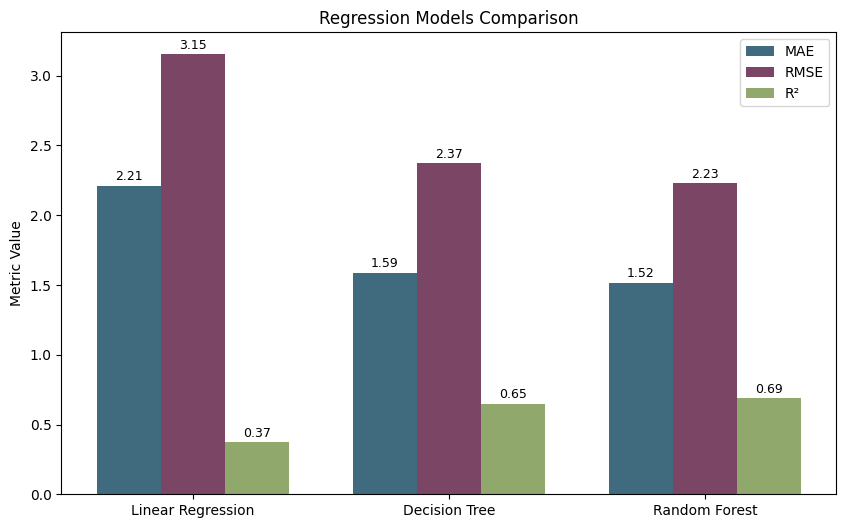

Random Forest Classifier performed the best out of all the regression models.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
MAE = [2.2109, 1.5865, 1.5176]
RMSE = [3.1533, 2.3719, 2.2273]
R2 = [0.3723, 0.6465, 0.6880]

metrics = np.array([MAE, RMSE, R2]).T  # shape (models x metrics)
metric_labels = ['MAE', 'RMSE', 'R²']
x = np.arange(len(models))
width = 0.25

# Choose colors for each metric
colors = ["#406b7e", "#7b4565", "#90a86b"]  # MAE, RMSE, R²

fig, ax = plt.subplots(figsize=(10,6))

for i in range(metrics.shape[1]):
    ax.bar(x + i*width, metrics[:, i], width, label=metric_labels[i], color=colors[i])

# Labels & Titles
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.set_ylabel('Metric Value')
ax.set_title('Regression Models Comparison')
ax.legend()
for i in range(len(models)):
    for j in range(metrics.shape[1]):
        ax.text(i + j*width, metrics[i,j] + 0.02, f'{metrics[i,j]:.2f}', ha='center', va='bottom', fontsize=9)

plt.show()


print("Random Forest Classifier performed the best out of all the regression models.")

## <font face="Gramond" color="teal"> b. Classification Models </font>

## <font face="Gramond" color="pink"> i. Logistic Regression </font>

In [ ]:
import numpy as np

# Logistic Regression
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iterations=2000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.classifiers = {}
        self.classes = None

    # Sigmoid function
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # Fit binary classifier for one-vs-rest
    def fit_binary(self, X, y):
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0

        for i in range(self.n_iterations):
            linear_model = np.dot(X, w) + b
            y_pred = self.sigmoid(linear_model)

            # Gradient descent
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            w -= self.learning_rate * dw
            b -= self.learning_rate * db

        return w, b

    # Fit OvR
    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            # Create binary target: 1 for this class, 0 for all others
            y_binary = (y == cls).astype(int)
            w, b = self.fit_binary(X, y_binary)
            self.classifiers[cls] = (w, b)

    # Predict probabilities for each class
    def predict_proba(self, X):
        probs = []
        for cls in self.classes:
            w, b = self.classifiers[cls]
            probs.append(self.sigmoid(np.dot(X, w) + b))
        return np.array(probs).T  # shape: (n_samples, n_classes)

    # Predict class with highest probability
    def predict(self, X):
        probs = self.predict_proba(X)
        class_indices = np.argmax(probs, axis=1)
        return self.classes[class_indices]


In [ ]:
# Metrics
def accuracy_score_mc(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1_mc(y_true, y_pred):
    classes = np.unique(y_true)
    precision_list, recall_list, f1_list = [], [], []

    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))

        precision = tp / (tp + fp + 1e-15)
        recall = tp / (tp + fn + 1e-15)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-15)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)


In [ ]:
# K-Fold Evaluation
def kfold_evaluate(model_class, X, y, k=5, **model_params):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.seed(42)
    np.random.shuffle(indices)

    fold_sizes = (n_samples // k) * np.ones(k, dtype=int)
    fold_sizes[:n_samples % k] += 1
    current = 0

    acc_list, prec_list, rec_list, f1_list = [], [], [], []

    for i, fold_size in enumerate(fold_sizes):
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])

        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        model = model_class(**model_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score_mc(y_test, y_pred)
        prec, rec, f1 = precision_recall_f1_mc(y_test, y_pred)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)

        print(f"Fold {i+1}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
        current = stop

    print("\nAverage CV Metrics:")
    print(f"Accuracy: {np.mean(acc_list):.4f}")
    print(f"Precision: {np.mean(prec_list):.4f}")
    print(f"Recall: {np.mean(rec_list):.4f}")
    print(f"F1-score: {np.mean(f1_list):.4f}")

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_genre_encoded = le.fit_transform(df_revenue['main_genre'].fillna('Unknown').values)

X = X_revenue_scaled.values
y = y_genre_encoded

kfold_evaluate(LogisticRegressionScratch, X, y, k=5, learning_rate=0.05, n_iterations=3000)


Fold 1: Accuracy=0.3586, Precision=0.1454, Recall=0.1311, F1=0.1274
Fold 2: Accuracy=0.3477, Precision=0.2742, Recall=0.1349, F1=0.1333
Fold 3: Accuracy=0.3587, Precision=0.1683, Recall=0.1282, F1=0.1254
Fold 4: Accuracy=0.3508, Precision=0.2374, Recall=0.1326, F1=0.1326
Fold 5: Accuracy=0.3470, Precision=0.1976, Recall=0.1363, F1=0.1359

Average CV Metrics:
Accuracy: 0.3525
Precision: 0.2046
Recall: 0.1326
F1-score: 0.1309


## <font face="Gramond" color="pink"> ii. KNN </font>

In [ ]:
import numpy as np
from collections import Counter

# KNN Classifier
class KNNScratch:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    # Fit method
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # Compute Euclidean distance
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    # Predict a single sample
    def predict_sample(self, x):
        # Compute distances to all training points
        distances = np.array([self.euclidean_distance(x, x_train) for x_train in self.X_train])
        # Get indices of k nearest neighbors
        k_idx = distances.argsort()[:self.k]
        # Majority vote
        k_neighbor_labels = self.y_train[k_idx]
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]

    # Predict all samples
    def predict(self, X):
        return np.array([self.predict_sample(x) for x in X])


In [ ]:
# Evaluation Metrics
def accuracy_score_manual(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1_manual(y_true, y_pred):
    classes = np.unique(y_true)
    precisions, recalls, f1s = [], [], []

    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

In [ ]:
# K-Fold Evaluation
def kfold_evaluate_knn(X, y, k_folds=5, k_neighbors=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    acc_list, prec_list, rec_list, f1_list = [], [], [], []

    fold_no = 1
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = KNNScratch(k=k_neighbors)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score_manual(y_test, y_pred)
        prec, rec, f1 = precision_recall_f1_manual(y_test, y_pred)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)

        print(f"Fold {fold_no}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
        fold_no += 1

    print("\nAverage CV Metrics:")
    print(f"Accuracy: {np.mean(acc_list):.4f}")
    print(f"Precision: {np.mean(prec_list):.4f}")
    print(f"Recall: {np.mean(rec_list):.4f}")
    print(f"F1-score: {np.mean(f1_list):.4f}")

X_knn = X_final_scaled[:, :200]  # first 200 features
y_knn = y_genre_encoded

kfold_evaluate_knn(X_knn, y_knn, k_folds=5, k_neighbors=7)


Fold 1: Accuracy=0.2594, Precision=0.1253, Recall=0.1055, F1=0.1083
Fold 2: Accuracy=0.2538, Precision=0.1577, Recall=0.1151, F1=0.1227
Fold 3: Accuracy=0.2481, Precision=0.1550, Recall=0.1049, F1=0.1125
Fold 4: Accuracy=0.2663, Precision=0.1505, Recall=0.1193, F1=0.1247
Fold 5: Accuracy=0.2663, Precision=0.1645, Recall=0.1235, F1=0.1295

Average CV Metrics:
Accuracy: 0.2588
Precision: 0.1506
Recall: 0.1136
F1-score: 0.1195


## <font face="Gramond" color="pink"> iii. Decision Tree Classifier </font>

In [ ]:
import numpy as np
from collections import Counter

# Decision Tree
class DecisionTreeFast:
    def __init__(self, max_depth=5, min_samples_split=20, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    # Gini Impurity
    def gini(self, y):
        classes = np.unique(y)
        impurity = 1.0
        for cls in classes:
            p = np.sum(y == cls) / len(y)
            impurity -= p ** 2
        return impurity

    # Split dataset
    def split_dataset(self, X, y, feature_idx, threshold):
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    # Find best split
    def best_split(self, X, y):
        n_samples, n_features = X.shape
        features = np.arange(n_features)

        # Feature subsampling for speed
        if self.max_features is not None and self.max_features < n_features:
            features = np.random.choice(n_features, self.max_features, replace=False)

        best_gain = 0
        best_feature, best_threshold = None, None
        current_gini = self.gini(y)

        for feature_idx in features:
            # Use percentiles instead of all unique values (fast)
            thresholds = np.percentile(X[:, feature_idx], [10, 25, 50, 75, 90])
            for t in thresholds:
                X_left, y_left, X_right, y_right = self.split_dataset(X, y, feature_idx, t)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gini_left = self.gini(y_left)
                gini_right = self.gini(y_right)
                weighted_gini = (len(y_left)/len(y))*gini_left + (len(y_right)/len(y))*gini_right
                gain = current_gini - weighted_gini
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = t
        return best_feature, best_threshold

    # Build tree recursively
    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        num_classes = len(np.unique(y))

        if depth >= self.max_depth or n_samples < self.min_samples_split or num_classes == 1:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {"type": "leaf", "class": leaf_value}

        feature, threshold = self.best_split(X, y)
        if feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {"type": "leaf", "class": leaf_value}

        X_left, y_left, X_right, y_right = self.split_dataset(X, y, feature, threshold)
        left_branch = self.build_tree(X_left, y_left, depth + 1)
        right_branch = self.build_tree(X_right, y_right, depth + 1)
        return {"type": "node", "feature": feature, "threshold": threshold,
                "left": left_branch, "right": right_branch}

    # Fit tree
    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    # Predict a single sample
    def predict_sample(self, x, node):
        if node["type"] == "leaf":
            return node["class"]
        if x[node["feature"]] <= node["threshold"]:
            return self.predict_sample(x, node["left"])
        else:
            return self.predict_sample(x, node["right"])

    # Predict all samples
    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])


In [ ]:
# Evaluation metrics
def accuracy_score_manual(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1_manual(y_true, y_pred):
    classes = np.unique(y_true)
    precisions, recalls, f1s = [], [], []

    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return np.mean(precisions), np.mean(recalls), np.mean(f1s)


In [ ]:
# K-Fold Evaluation
def kfold_evaluate_tree(X, y, k=5, max_depth=5, min_samples_split=20, max_features=None):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    acc_list, prec_list, rec_list, f1_list = [], [], [], []

    fold_no = 1
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = DecisionTreeFast(max_depth=max_depth, min_samples_split=min_samples_split, max_features=max_features)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score_manual(y_test, y_pred)
        prec, rec, f1 = precision_recall_f1_manual(y_test, y_pred)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)

        print(f"Fold {fold_no}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
        fold_no += 1

    print("\nAverage CV Metrics:")
    print(f"Accuracy: {np.mean(acc_list):.4f}")
    print(f"Precision: {np.mean(prec_list):.4f}")
    print(f"Recall: {np.mean(rec_list):.4f}")
    print(f"F1-score: {np.mean(f1_list):.4f}")

X_fast = X_final_scaled[:, :200]
y_fast = y_genre_encoded

kfold_evaluate_tree(X_fast, y_fast, k=5, max_depth=12, min_samples_split=10, max_features=100)


Fold 1: Accuracy=0.4930, Precision=0.4557, Recall=0.3261, F1=0.3637
Fold 2: Accuracy=0.4845, Precision=0.4779, Recall=0.3468, F1=0.3888
Fold 3: Accuracy=0.4962, Precision=0.4309, Recall=0.3222, F1=0.3523
Fold 4: Accuracy=0.4977, Precision=0.4404, Recall=0.3424, F1=0.3684
Fold 5: Accuracy=0.4902, Precision=0.4929, Recall=0.3632, F1=0.4059

Average CV Metrics:
Accuracy: 0.4923
Precision: 0.4596
Recall: 0.3402
F1-score: 0.3758


## <font face="Gramond" color="pink"> iv. Random Forest Classifier </font>

In [ ]:
import numpy as np
from collections import Counter

# Random Forest Classifier
class RandomForestScratch:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=20, max_features=None, sample_size=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.sample_size = sample_size
        self.trees = []

    # Fit all trees
    def fit(self, X, y):
        n_samples = X.shape[0]
        self.trees = []
        for _ in range(self.n_trees):
            # Bootstrap sample
            if self.sample_size is None:
                sample_size = n_samples
            else:
                sample_size = int(n_samples * self.sample_size)
            idxs = np.random.choice(n_samples, sample_size, replace=True)
            X_sample, y_sample = X[idxs], y[idxs]

            tree = DecisionTreeFast(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    # Predict a single sample using majority vote
    def predict_sample(self, x):
        predictions = [tree.predict_sample(x, tree.tree) for tree in self.trees]
        return Counter(predictions).most_common(1)[0][0]

    # Predict all samples
    def predict(self, X):
        return np.array([self.predict_sample(x) for x in X])


In [ ]:
# Evaluation Metrics
def accuracy_score_manual(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1_manual(y_true, y_pred):
    classes = np.unique(y_true)
    precisions, recalls, f1s = [], [], []

    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return np.mean(precisions), np.mean(recalls), np.mean(f1s)


In [ ]:
# K-Fold Evaluation
def kfold_evaluate_random_forest(X, y, k=5, n_trees=10, max_depth=7, min_samples_split=20, max_features=None, sample_size=0.8):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    acc_list, prec_list, rec_list, f1_list = [], [], [], []

    fold_no = 1
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = RandomForestScratch(
            n_trees=n_trees,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features,
            sample_size=sample_size
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score_manual(y_test, y_pred)
        prec, rec, f1 = precision_recall_f1_manual(y_test, y_pred)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)

        print(f"Fold {fold_no}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
        fold_no += 1

    print("\nAverage CV Metrics:")
    print(f"Accuracy: {np.mean(acc_list):.4f}")
    print(f"Precision: {np.mean(prec_list):.4f}")
    print(f"Recall: {np.mean(rec_list):.4f}")
    print(f"F1-score: {np.mean(f1_list):.4f}")


In [ ]:
X_rf = X_final_scaled[:, :200]  # first 200 features
y_rf = y_genre_encoded

kfold_evaluate_random_forest(
    X_rf, y_rf,
    k=5,
    n_trees=15,               # more trees usually improves accuracy
    max_depth=10,
    min_samples_split=10,
    max_features=50,
    sample_size=0.8
)


Fold 1: Accuracy=0.5422, Precision=0.5650, Recall=0.3154, F1=0.3682
Fold 2: Accuracy=0.5390, Precision=0.6606, Recall=0.3471, F1=0.4106
Fold 3: Accuracy=0.5398, Precision=0.6181, Recall=0.3351, F1=0.3872
Fold 4: Accuracy=0.5420, Precision=0.6231, Recall=0.3368, F1=0.3891
Fold 5: Accuracy=0.5473, Precision=0.6534, Recall=0.3627, F1=0.4249

Average CV Metrics:
Accuracy: 0.5421
Precision: 0.6240
Recall: 0.3394
F1-score: 0.3960


## <font face="Gramond" color="peachpuff"> Comparison </font>

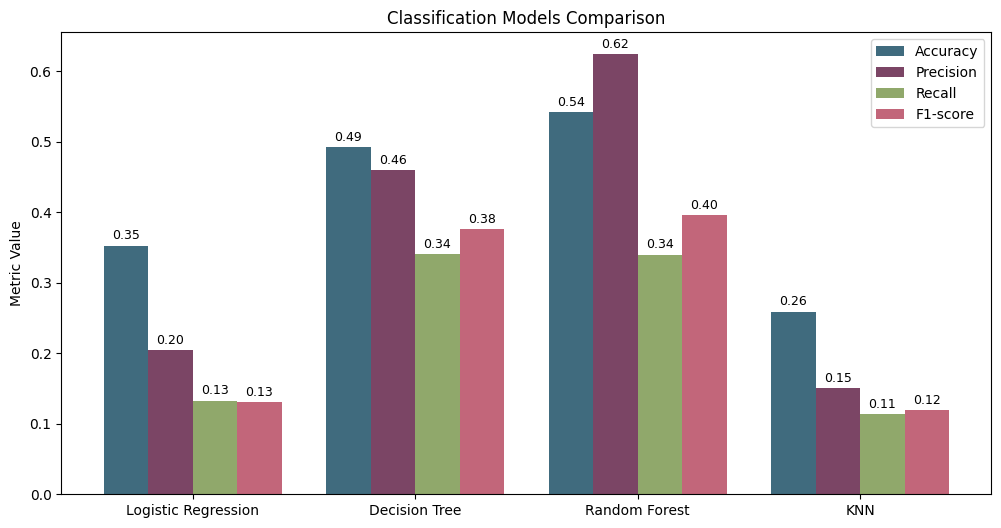

Random Forest Classifier performed the best out of all the classification models.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN']

# Average metrics from your results
Accuracy = [0.3525, 0.4923, 0.5421, 0.2588]
Precision = [0.2046, 0.4596, 0.6240, 0.1506]
Recall = [0.1326, 0.3402, 0.3394, 0.1136]
F1 = [0.1309, 0.3758, 0.3960, 0.1195]

metrics = np.array([Accuracy, Precision, Recall, F1]).T  # shape (models x metrics)
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(models))
width = 0.2

# Colors for each metric
colors = ["#406b7e", "#7b4565", "#90a86b", "#c2667a"]  # Accuracy, Precision, Recall, F1

fig, ax = plt.subplots(figsize=(12,6))

# Plot bars
for i in range(metrics.shape[1]):
    ax.bar(x + i*width, metrics[:, i], width, label=metric_labels[i], color=colors[i])

ax.set_xticks(x + 1.5*width)
ax.set_xticklabels(models)
ax.set_ylabel('Metric Value')
ax.set_title('Classification Models Comparison')
ax.legend()

for i in range(len(models)):
    for j in range(metrics.shape[1]):
        ax.text(i + j*width, metrics[i,j] + 0.005, f'{metrics[i,j]:.2f}', ha='center', va='bottom', fontsize=9)

plt.show()

print("Random Forest Classifier performed the best out of all the classification models.")

## <font face="Gramond" color="peachpuff"> TinyML Deployment </font>

In [18]:
rf = ScratchRandomForestRegressor(
    n_trees=20, max_depth=7, min_samples_split=20
)
rf.fit(X, y)
y_rf = rf.predict(X)


Trained tree 1/20
Trained tree 2/20
Trained tree 3/20
Trained tree 4/20
Trained tree 5/20
Trained tree 6/20
Trained tree 7/20
Trained tree 8/20
Trained tree 9/20
Trained tree 10/20
Trained tree 11/20
Trained tree 12/20
Trained tree 13/20
Trained tree 14/20
Trained tree 15/20
Trained tree 16/20
Trained tree 17/20
Trained tree 18/20
Trained tree 19/20
Trained tree 20/20


In [19]:
import tensorflow as tf
import time

tiny_dnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

tiny_dnn.compile(optimizer='adam', loss='mse', metrics=['mae'])
tiny_dnn.fit(X, y_rf, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 59.1107 - mae: 5.8275 - val_loss: 8.4086 - val_mae: 2.0686
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2825 - mae: 1.9480 - val_loss: 6.6522 - val_mae: 1.8783
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8451 - mae: 1.7171 - val_loss: 5.7144 - val_mae: 1.7127
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6110 - mae: 1.5552 - val_loss: 5.4652 - val_mae: 1.8037
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7722 - mae: 1.4114 - val_loss: 4.0690 - val_mae: 1.4527
Epoch 6/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0214 - mae: 1.2495 - val_loss: 3.4447 - val_mae: 1.3258
Epoch 7/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6229 - mae: 1.1302 - val_loss: 3.1190 - val_mae: 1.2459
Epoch 8/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2068 - mae: 1.0477 - val_loss: 3.0812 - val_mae: 1.2474
Epoch 9/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - l

In [ ]:
# TFLITE CONVERSION
tflite_model = tf.lite.TFLiteConverter.from_keras_model(tiny_dnn).convert()
with open("tiny_dnn_model.tflite","wb") as f:
    f.write(tflite_model)

# Quantized TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(tiny_dnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open("tiny_dnn_model_quant.tflite","wb") as f:
    f.write(tflite_quant_model)

Saved artifact at '/tmp/tmphibtldt5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 111), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135202647356240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135202647357392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135202647356048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135202647353936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135202647357968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135202647354896: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmpl4acku69'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 111), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135202647356240: TensorSpe

In [21]:
import tensorflow as tf
import numpy as np

# Train your model
tiny_dnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

tiny_dnn.compile(optimizer='adam', loss='mse', metrics=['mae'])
tiny_dnn.fit(X, y_rf, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# SOLUTION 1: Full integer quantization (RECOMMENDED for Edge Impulse)
def representative_dataset():
    """Provide representative data for quantization"""
    for i in range(100):
        # Use actual training data samples
        yield [X[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(tiny_dnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
# Force all operations to int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()
with open("tiny_dnn_edge_impulse.tflite", "wb") as f:
    f.write(tflite_quant_model)

# SOLUTION 2: If Solution 1 fails, use float16 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(tiny_dnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_float16_model = converter.convert()
with open("tiny_dnn_float16.tflite", "wb") as f:
    f.write(tflite_float16_model)

# SOLUTION 3: Basic conversion without advanced quantization
converter = tf.lite.TFLiteConverter.from_keras_model(tiny_dnn)
# Use older opset that Edge Impulse definitely supports
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS  # Use default builtins
]

tflite_basic_model = converter.convert()
with open("tiny_dnn_basic.tflite", "wb") as f:
    f.write(tflite_basic_model)

print("Three versions created. Try uploading them in this order:")
print("1. tiny_dnn_edge_impulse.tflite (int8 quantized)")
print("2. tiny_dnn_float16.tflite (float16)")
print("3. tiny_dnn_basic.tflite (basic float32)")

Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 64.4487 - mae: 6.1691 - val_loss: 7.7844 - val_mae: 2.0836
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.2785 - mae: 1.9539 - val_loss: 6.2465 - val_mae: 1.8162
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.9327 - mae: 1.7185 - val_loss: 5.7310 - val_mae: 1.7690
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.8658 - mae: 1.5895 - val_loss: 4.8692 - val_mae: 1.6080
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.8431 - mae: 1.4287 - val_loss: 4.1514 - val_mae: 1.4536
Epoch 6/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.3949 - mae: 1.2996 - val_loss: 3.5395 - val_mae: 1.3537
Epoch 7/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.7777 - mae: 1.1748 - val_loss: 3.1691 - val_mae: 1.2650
Epoch 8/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4599 - mae: 1.0989 - val_loss: 3.0134 - val_mae: 1.2418
Epoch 9/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

In [ ]:
# MODEL SIZE CHECK
print(f"Regular TFLite size: {len(tflite_model)/1024:.2f} KB")
print(f"Quantized TFLite size: {len(tflite_quant_model)/1024:.2f} KB")

# INFERENCE SPEED TEST
sample = np.random.rand(1, X.shape[1]).astype(np.float32)

# Keras model inference
start = time.time()
tiny_dnn.predict(sample)
keras_time = time.time() - start
print(f"Keras model inference time: {keras_time*1000:.3f} ms")

# Quantized TFLite inference
interpreter = tf.lite.Interpreter(model_path="tiny_dnn_model_quant.tflite")
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

start = time.time()
interpreter.set_tensor(input_index, sample)
interpreter.invoke()
output = interpreter.get_tensor(output_index)
tflite_time = time.time() - start
print(f"TFLite quantized inference time: {tflite_time*1000:.3f} ms")

Regular TFLite size: 38.09 KB
Quantized TFLite size: 12.44 KB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Keras model inference time: 453.985 ms
TFLite quantized inference time: 0.391 ms


In [ ]:
# COMPARE TINYML VS RANDOM FOREST
y_pred_tiny = tiny_dnn.predict(X)
mae = mean_absolute_error(y_rf, y_pred_tiny)
rmse = np.sqrt(mean_squared_error(y_rf, y_pred_tiny))
print(f"TinyML vs Random Forest -> MAE: {mae:.4f}, RMSE: {rmse:.4f}")

413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TinyML vs Random Forest -> MAE: 0.6121, RMSE: 0.9218


In [ ]:
from google.colab import files

files.download("tiny_dnn_model.tflite")
files.download("tiny_dnn_model_quant.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## <font face="Gramond" color="peachpuff"> Screenshot from Edge Impulse </font>

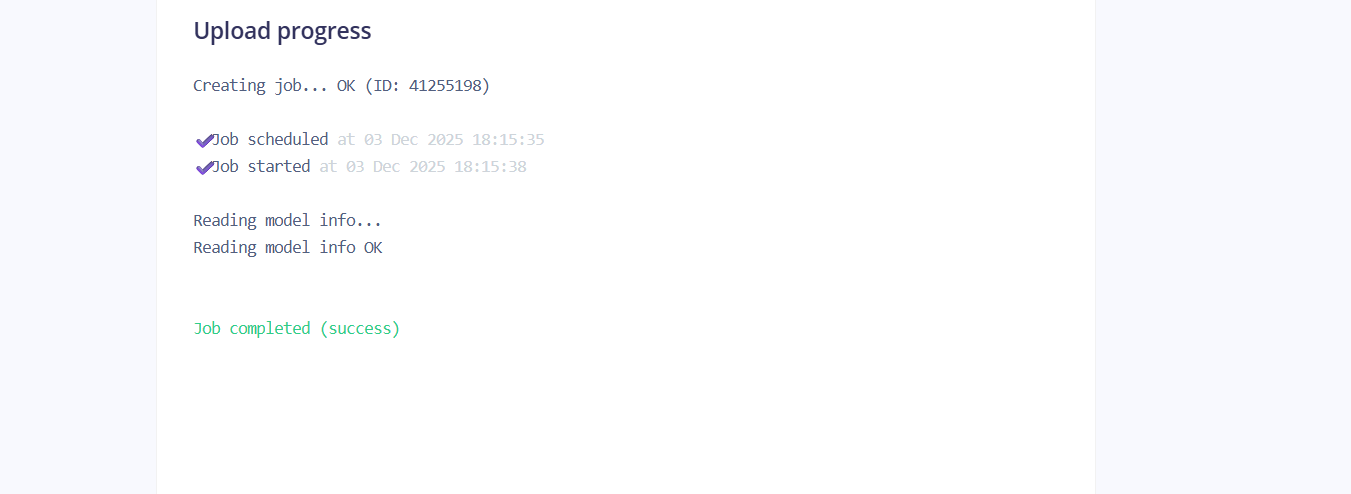


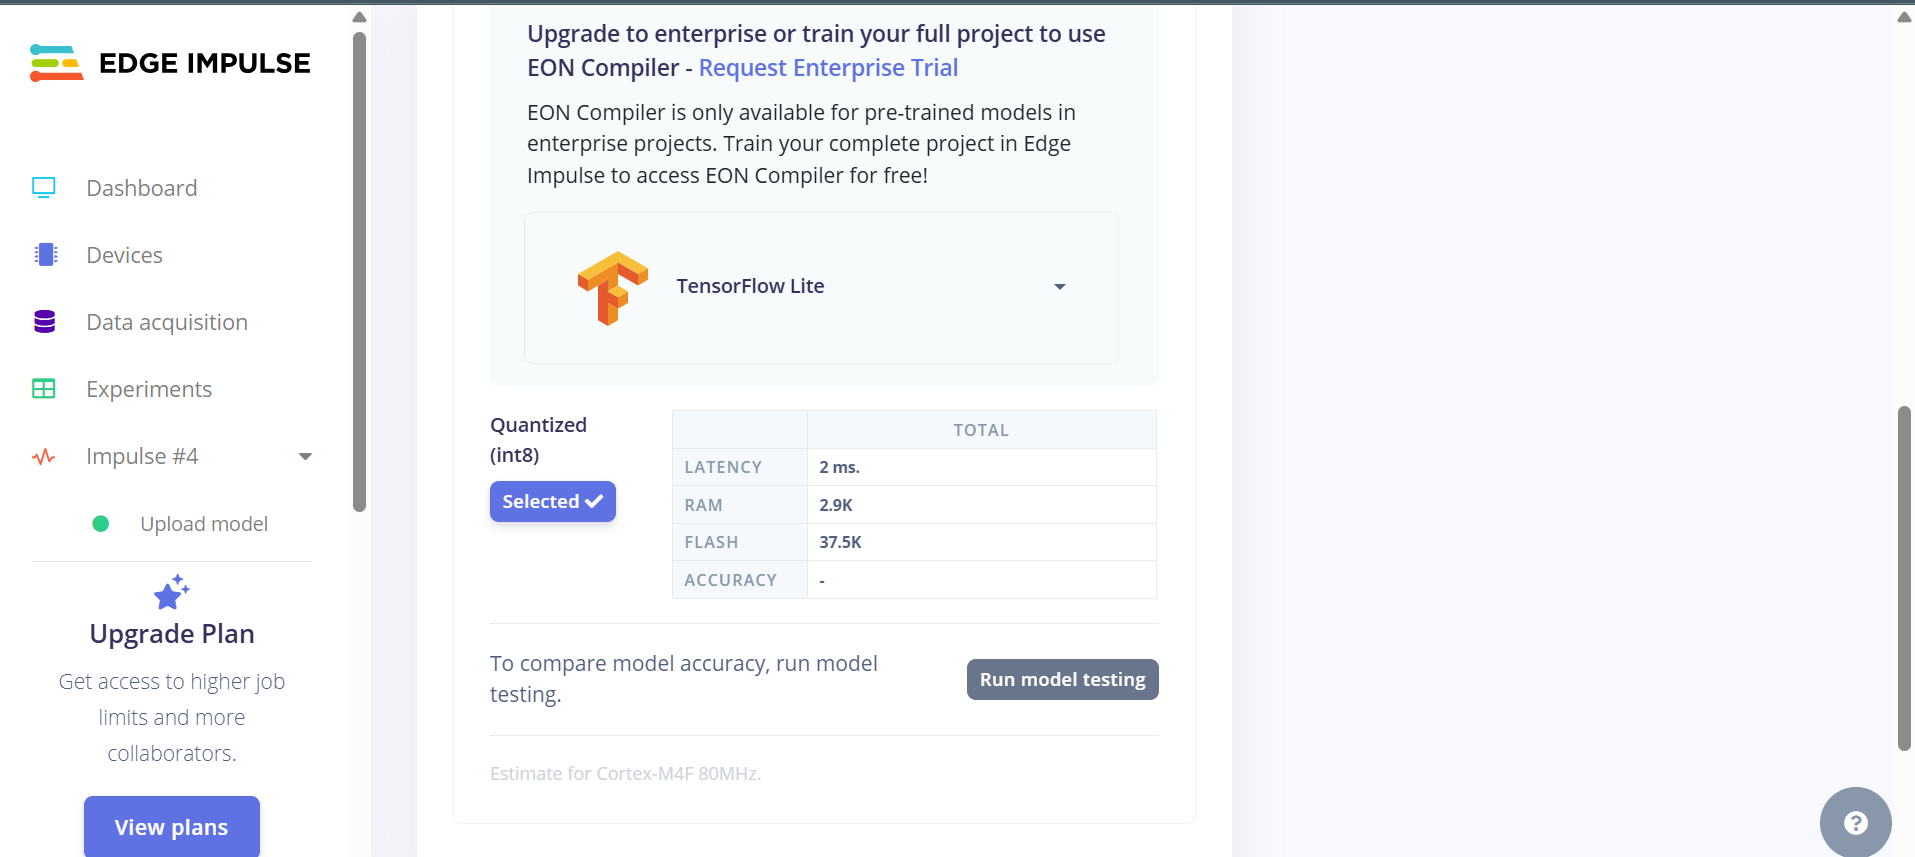

## <font face="Gramond" color="pink"> Flash/Storage Usage </font>

In [ ]:
import os

file_size = os.path.getsize("tiny_dnn_model_quant.tflite") / 1024  # KB
print(f"Quantized TFLite model size: {file_size:.2f} KB")


Quantized TFLite model size: 12.44 KB


## <font face="Gramond" color="teal"> RAM Usage (Tensor Memory During Inference) </font>

In [ ]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="tiny_dnn_model_quant.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

total_ram = 0
for tensor in interpreter.get_tensor_details():
    shape = tensor['shape']
    dtype = tensor['dtype']
    size_bytes = tf.dtypes.as_dtype(dtype).size * tf.reduce_prod(shape).numpy()
    total_ram += size_bytes

print(f"Approx. RAM used by tensors: {total_ram/1024:.2f} KB")

Approx. RAM used by tensors: 10.25 KB


## <font face="Gramond" color="purple"> Latency / Inference time </font>

In [ ]:
import time
import numpy as np

sample = np.random.rand(1, X.shape[1]).astype(np.float32)

# Quantized TFLite inference
start = time.time()
interpreter.set_tensor(input_index, sample)
interpreter.invoke()
output = interpreter.get_tensor(output_index)
tflite_time = time.time() - start
print(f"TFLite quantized inference time: {tflite_time*1000:.3f} ms")


TFLite quantized inference time: 0.458 ms


In [ ]:
runs = 100
times = []
for _ in range(runs):
    start = time.time()
    interpreter.set_tensor(input_index, sample)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)
    times.append(time.time() - start)

print(f"Average latency over {runs} runs: {np.mean(times)*1000:.3f} ms")


Average latency over 100 runs: 0.007 ms


## <font face="Gramond" color="peachpuff"> Bonus Task </font>

*   ## <font face="Gramond" color="pink"> Visualizations </font>



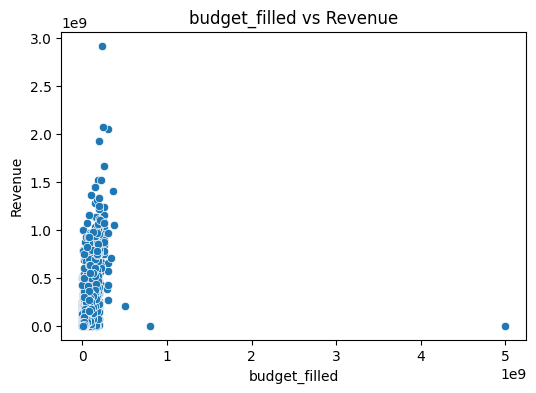

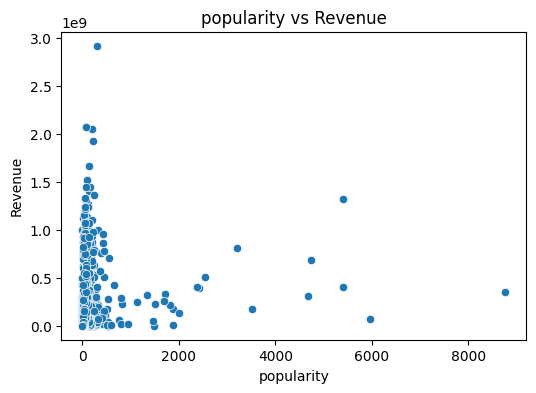

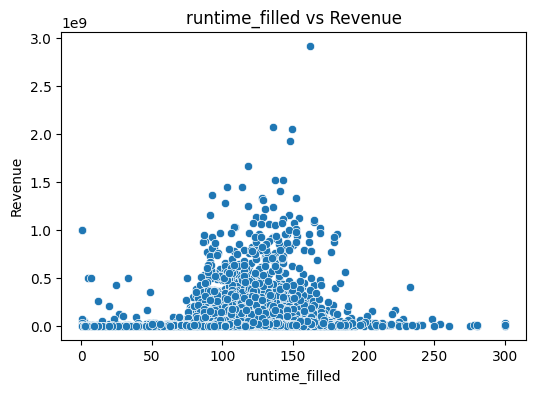

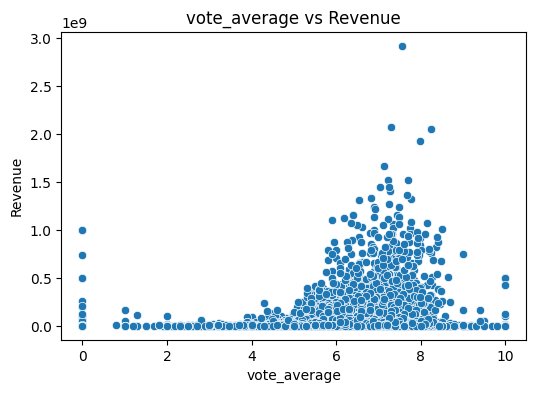

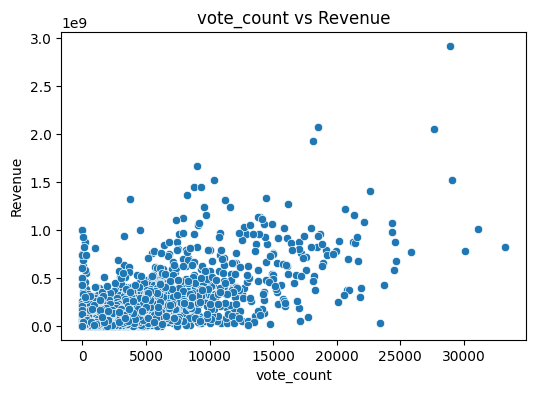

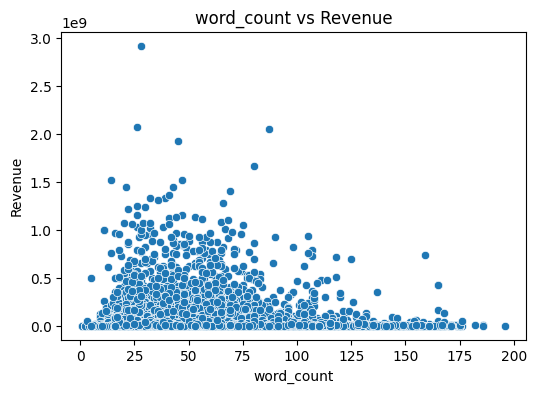

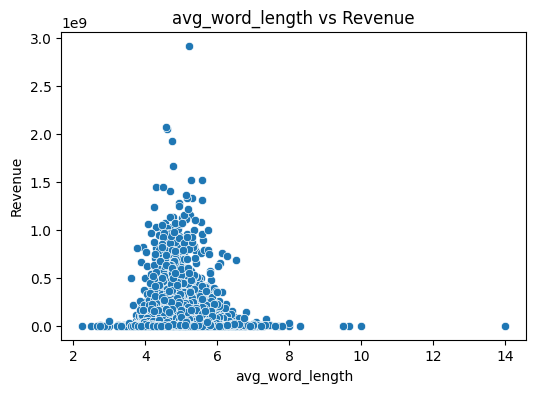

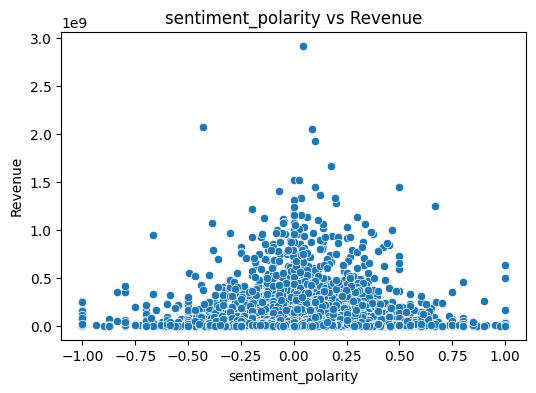

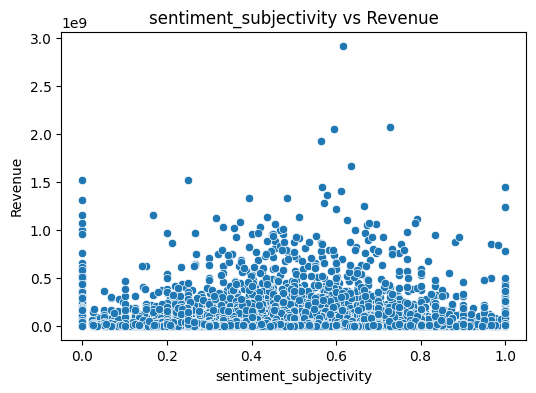

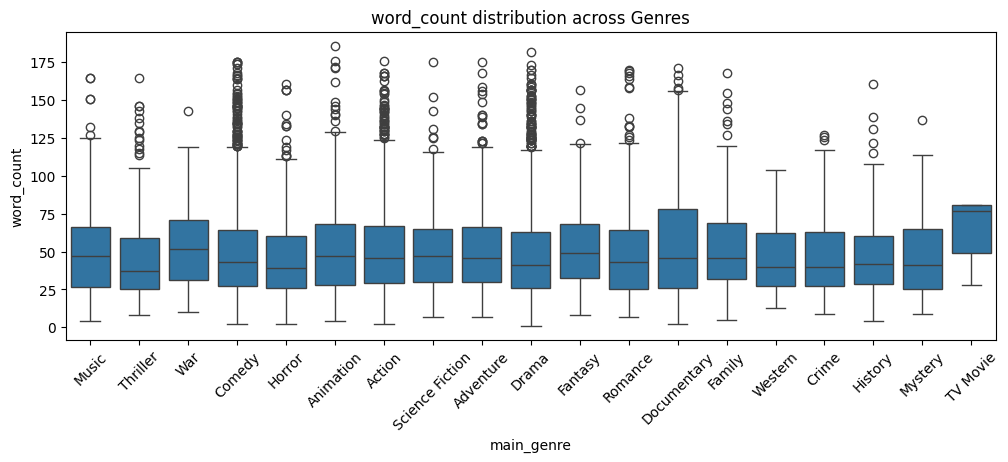

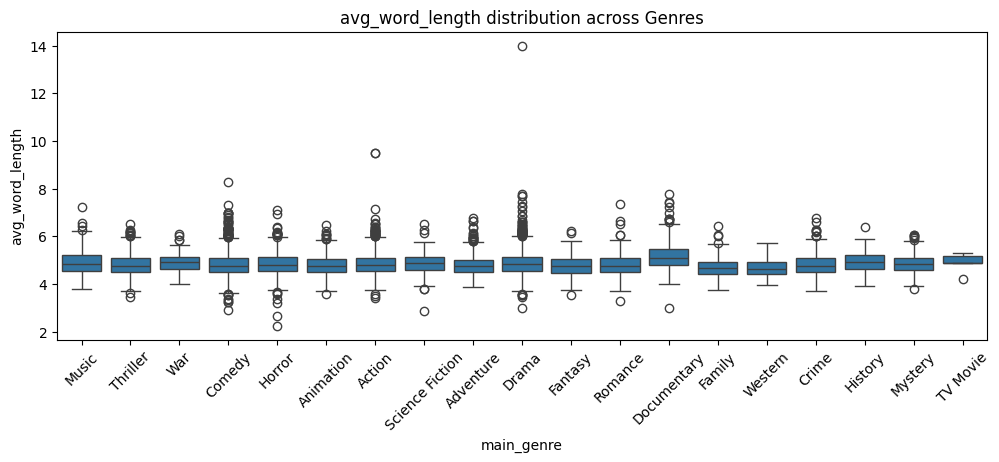

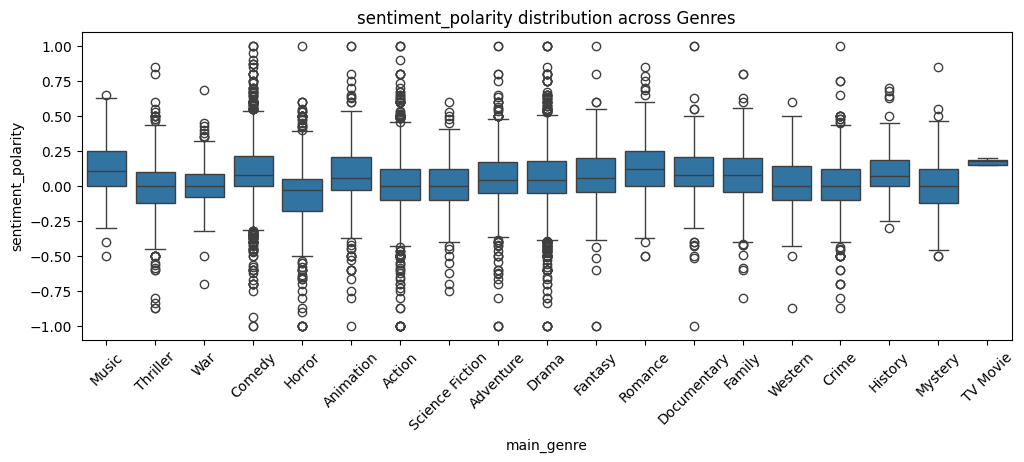

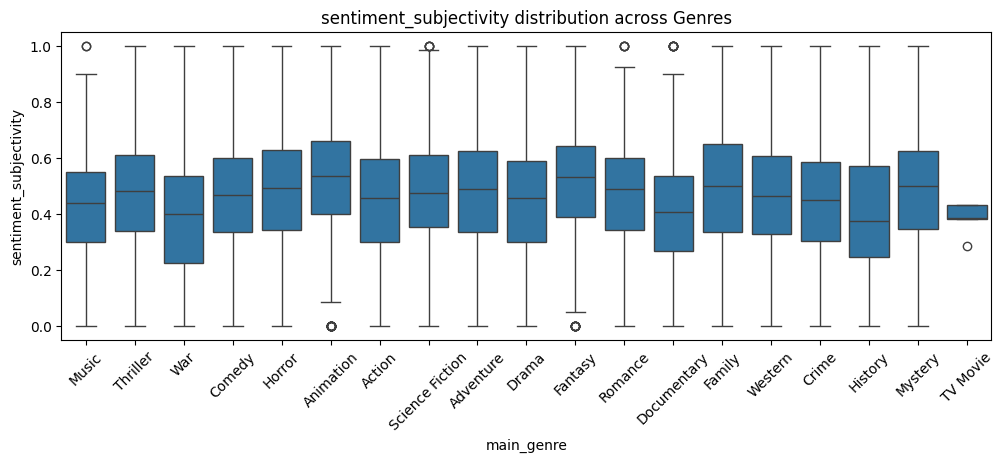

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric features vs Revenue
numeric_features_to_plot = ['budget_filled', 'popularity', 'runtime_filled',
                            'vote_average', 'vote_count', 'word_count',
                            'avg_word_length', 'sentiment_polarity', 'sentiment_subjectivity']

for feature in numeric_features_to_plot:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_revenue, x=feature, y='revenue')
    plt.title(f'{feature} vs Revenue')
    plt.xlabel(feature)
    plt.ylabel('Revenue')
    plt.show()

# Boxplot: Feature vs Main Genre
for feature in ['word_count', 'avg_word_length', 'sentiment_polarity', 'sentiment_subjectivity']:
    plt.figure(figsize=(12,4))
    sns.boxplot(data=df_revenue, x='main_genre', y=feature)
    plt.title(f'{feature} distribution across Genres')
    plt.xticks(rotation=45)
    plt.show()


*   ## <font face="Gramond" color="pink"> Clustering Reviews </font>



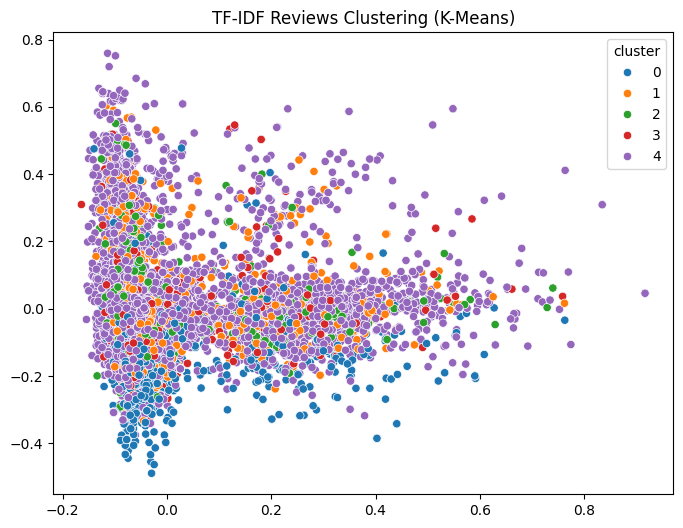

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Use the TF-IDF matrix from df_revenue
tfidf_matrix = overview_tfidf_revenue.toarray()

# K-Means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

df_revenue['cluster'] = clusters

# Optional: PCA to reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
tfidf_2d = pca.fit_transform(tfidf_matrix)

plt.figure(figsize=(8,6))
sns.scatterplot(x=tfidf_2d[:,0], y=tfidf_2d[:,1], hue=df_revenue['cluster'], palette='tab10')
plt.title('TF-IDF Reviews Clustering (K-Means)')
plt.show()


*   ## <font face="Gramond" color="pink"> Outlier Detection </font>



Outlier counts:
outlier
 1    13069
-1      132
Name: count, dtype: int64


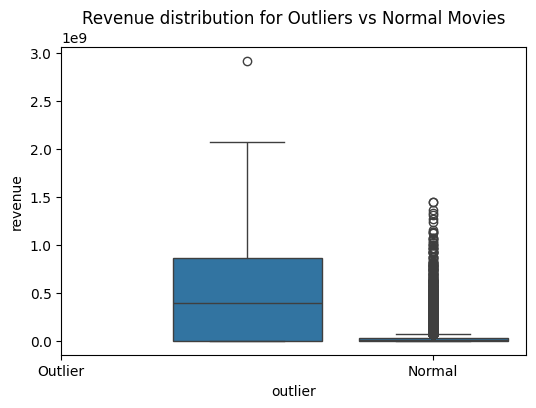

In [ ]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Define numeric columns explicitly for outlier detection
numeric_cols_for_outlier = [
    'budget_filled', 'popularity', 'runtime_filled',
    'vote_average', 'vote_count', 'has_budget', 'has_votes',
    'word_count', 'avg_word_length', 'sentiment_polarity', 'sentiment_subjectivity'
]

# Select numeric data
numeric_data = df_revenue[numeric_cols_for_outlier]

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(numeric_data)

# Add outlier labels to dataframe (-1 = outlier, 1 = normal)
df_revenue['outlier'] = outliers

# Check number of outliers
print("Outlier counts:")
print(df_revenue['outlier'].value_counts())

# Visualize impact of outliers on revenue
plt.figure(figsize=(6,4))
sns.boxplot(data=df_revenue, x='outlier', y='revenue')
plt.title('Revenue distribution for Outliers vs Normal Movies')
plt.xticks([-1,1], ['Outlier', 'Normal'])
plt.show()
